In [2]:
''' Let's create a minimum model for ResNet in Keras, using flowers. 
        
    Reference tutorials,
    
        https://www.kaggle.com/rajmehra03/flower-recognition-cnn-keras
'''

import os, json, itertools
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from skimage.transform import resize

from keras.preprocessing.image import img_to_array, load_img 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

im_w, im_h, im_c = 256, 256, 3

In [15]:
BASE_DIR = '../datasets/learn_ai/BreaKHis_400X'
TRAIN_DIR = '../datasets/learn_ai/BreaKHis_400X/train'
TEST_DIR = '../datasets/learn_ai/BreaKHis_400X/test'
MY_DATA_DIR = '../mydatadir/learn_ai/BreaKHis_400X'

In [19]:
paths_benign = os.listdir(os.path.join(TRAIN_DIR, 'benign'))
paths_malignant = os.listdir(os.path.join(TRAIN_DIR, 'malignant'))
n_classes = 2

In [23]:
n_benign = len(paths_benign)
n_malignant = len(paths_malignant)
n_train = n_benign + n_malignant

In [36]:
X = np.empty(shape=(n_train, im_w, im_h, im_c), dtype='f4')
y = np.empty(n_train, dtype=int)

for i, img_path in enumerate(paths_benign):
    im = load_img(os.path.join(TRAIN_DIR, 'benign/' + img_path))
    im = img_to_array(im)
    im = resize(im, (im_w, im_h, im_c), mode='constant', 
                preserve_range=True)
    X[i] = im / 255.0
    y[i] = 1
    
for i, img_path in enumerate(paths_malignant):
    im = load_img(os.path.join(TRAIN_DIR, 'malignant/' + img_path))
    im = img_to_array(im)
    im = resize(im, (im_w, im_h, im_c), mode='constant', 
                preserve_range=True)
    
    X[n_benign + i] = im / 255.0
    y[n_benign + i] = 0

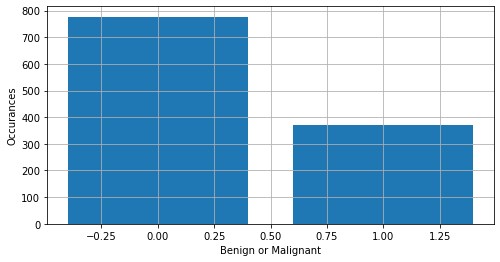

In [37]:
nums, counts = np.unique(y, return_counts=True)

fig, ax = plt.subplots(1, figsize=(8, 4)) 

ax.bar(nums, counts)
ax.set_title('')
ax.set_xlabel('Benign or Malignant')
ax.set_ylabel('Occurances')

ax.grid() 

In [38]:
y_hot = to_categorical(y, num_classes=n_classes) 

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_hot, 
    test_size = 0.1, 
    random_state = 3) 

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1033, 128, 128, 3)
(115, 128, 128, 3)
(1033, 2)
(115, 2)


In [39]:
''' CNN architechture 
        In -> [ (Conv2D -> relu) * 2
           ->    MaxPool2D 
           ->    Dropout ] * 2 
           -> Flatten 
           -> Dense 
           -> Dropout 
           -> Out
'''

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (im_w,im_h,im_c)))

model.add(Conv2D(filters=2, kernel_size=(5,5),
                 padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(5,5),
                 padding = 'Same', 
                 activation ='relu'))

model.add(Conv2D(filters=32, kernel_size=(5,5),
                 padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), 
                    strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = "softmax"))

In [40]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy", 
              metrics = ["accuracy"]) 


learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

checkpoint = ModelCheckpoint('01_learn_flowers.h5', 
                              verbose = 1, 
                              save_best_only = True, 
                              save_weights_only = True)

In [41]:
datagen = ImageDataGenerator(
        
    featurewise_center = False,  
    samplewise_center = False,  

    featurewise_std_normalization = False,  
    samplewise_std_normalization = False,  
    
    zca_whitening = False,  
    
    # Augment
    
    rotation_range = 10,  
    
    zoom_range = 0.1, 
    
    width_shift_range = 0.1,  
    height_shift_range = 0.1
)

datagen.fit(X_train)

In [42]:
epochs = 24
batch_size = 86

history = model.fit(
    datagen.flow(X_train, y_train, batch_size = batch_size),
    epochs = epochs, 
    validation_data = (X_valid, y_valid),
    verbose = 2,
    steps_per_epoch = X_train.shape[0] // batch_size, 
    callbacks = [learning_rate_reduction, checkpoint]
)

Epoch 1/24

Epoch 00001: val_loss improved from inf to 0.63482, saving model to 01_learn_flowers.h5
12/12 - 10s - loss: 4.9201 - accuracy: 0.5824 - val_loss: 0.6348 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 2/24

Epoch 00002: val_loss improved from 0.63482 to 0.63431, saving model to 01_learn_flowers.h5
12/12 - 10s - loss: 0.6353 - accuracy: 0.6758 - val_loss: 0.6343 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 3/24

Epoch 00003: val_loss did not improve from 0.63431
12/12 - 9s - loss: 0.6399 - accuracy: 0.6748 - val_loss: 0.6345 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 4/24

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_loss improved from 0.63431 to 0.63396, saving model to 01_learn_flowers.h5
12/12 - 9s - loss: 0.6230 - accuracy: 0.6948 - val_loss: 0.6340 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 5/24

Epoch 00005: val_loss improved from 0.63396 to 0.63393, saving model to 01_learn_flowers.h5
12/12 - 9s - loss: 0.6339 - accuracy: 0.67

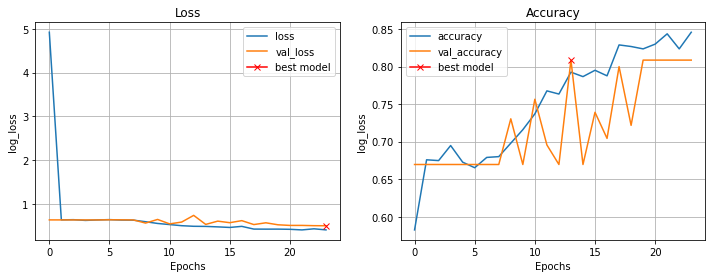

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.plot(np.argmin(history.history['val_loss']), 
         np.min(history.history['val_loss']), 
                marker='x', color='r', label='best model')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('log_loss')
ax1.set_title('Loss')
ax1.legend()
ax1.grid()

# Accuracy
ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.plot(np.argmax(history.history["val_accuracy"]), 
         np.max(history.history["val_accuracy"]), 
                marker='x', color='r', label='best model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('log_loss')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid()

plt.show() 

In [43]:
y_pred = model.predict(X_valid)
y_pred_hot = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_valid, axis=1)

Cm = np.array(confusion_matrix(y_true, y_pred_hot)) 

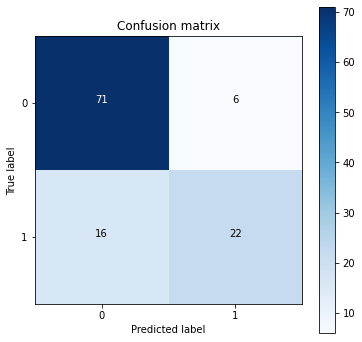

In [44]:
# Plot the confusion matrix

fig, ax = plt.subplots(1, figsize=(6, 6))

im = ax.imshow(Cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im)

ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

thresh = Cm.max() / 2.
for i, j in itertools.product(range(Cm.shape[0]), 
                              range(Cm.shape[1])):
    ax.text(j, i, Cm[i, j],
             horizontalalignment = "center",
             color= "white" if Cm[i, j] > thresh else "black")

ticks = list(range(n_classes))
tick_labels = np.arange(len(ticks))
    
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)

plt.show() 

In [45]:
errors = (y_pred_hot - y_true != 0)

y_pred_hot_errors = y_pred_hot[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_valid_errors = X_valid[errors] 

In [46]:
# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)
# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, 
                                       y_true_errors, axis=1))
# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors
# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors) 

In [57]:
X_valid_errors[0].shape
most_important_errors.shape
errors.shape

(115,)

In [60]:
'''
most_important_errors = errors[-16:]

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

n = 0
nrows = 4
ncols = 4

for i, ax in enumerate(axes.flatten()):
    error = most_important_errors[i]
    
    ax.imshow((X_valid_errors[error]).reshape((256,256,3)))
    
    pred_label = y_pred_hot_errors[error] 
    true_label = y_true_errors[error]
    
    s = "Predicted: {}\nTrue: {}".format(pred_label, true_label)
    
    ax.set_title(s)
    ax.axis('off')
    
fig.tight_layout() '''

'\nmost_important_errors = errors[-16:]\n\nfig, axes = plt.subplots(4, 4, figsize=(8, 8))\n\nn = 0\nnrows = 4\nncols = 4\n\nfor i, ax in enumerate(axes.flatten()):\n    error = most_important_errors[i]\n    \n    ax.imshow((X_valid_errors[error]).reshape((256,256,3)))\n    \n    pred_label = y_pred_hot_errors[error] \n    true_label = y_true_errors[error]\n    \n    s = "Predicted: {}\nTrue: {}".format(pred_label, true_label)\n    \n    ax.set_title(s)\n    ax.axis(\'off\')\n    \nfig.tight_layout() '